In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


file_path = r'C:\Users\nacho\OneDrive - University of Birmingham\DATA SCIENCE\Summer Project\all_player_data.csv'
df = pd.read_csv(file_path)



✅ Best combination:
n_neighbors=10, min_dist=0.0, k=3, silhouette=0.459


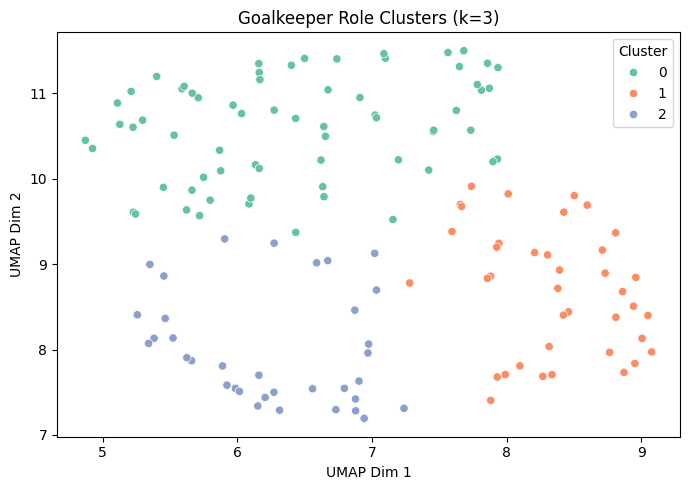

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Target position
target_position = 'goalkeeper'  # change as needed

# Filter and select features
group = df[df["position"].str.lower() == target_position.lower()].copy()

usable_features = [
    'shots_faced_per_90', 'saves_per_90', 'goals_conceded_per_90',
     'collections_per_90', 'punches_per_90',
    'sweeper_claims_per_90', 'sweeper_clears_per_90', 'save_percentage', 'collection_success_rate', 'punch_success_rate', 'sweeper_success_rate',
    
    'passes_per_90', 'pass_accuracy', 'progressive_passes_per_90',
    'progressive_pass_accuracy', 'long_passes_per_90', 'long_pass_accuracy', 'key_passes_per_90',
    'passes_received_per_90', 
    
    #'duels_per_90', 'duels_won_per_90', 'duel_success_rate',
    'touches_per_90', 'average_position_x', 'average_position_y',
    #'smothers_per_90' 'smother_success_rate'
]

# Drop NAs and scale
X = group[usable_features].dropna()
if len(X) < 10:
    print("Not enough valid rows for clustering.")
    exit()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP grid search parameters
n_neighbors_list = [ 5, 10, 15, 30, 50]
min_dist_list = [0.0, 0.05, 0.1,0.3, 0.5, 0.7]

best_score = -1
best_params = None
best_embedding = None
best_k = None
best_labels = None

# Try all combinations
for n in n_neighbors_list:
    for d in min_dist_list:
        reducer = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2, random_state=42)
        X_umap = reducer.fit_transform(X_scaled)

        for k in range(2, 5):  # try k=2 to k=5
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_umap)
            score = silhouette_score(X_umap, labels)

            #print(f"n_neighbors={n}, min_dist={d}, k={k}, silhouette={score:.3f}")
            
            if score > best_score:
                best_score = score
                best_params = (n, d)
                best_embedding = X_umap
                best_k = k
                best_labels = labels

# Report best
print("\n✅ Best combination:")
print(f"n_neighbors={best_params[0]}, min_dist={best_params[1]}, k={best_k}, silhouette={best_score:.3f}")

# Plot best result
plt.figure(figsize=(7, 5))
sns.scatterplot(x=best_embedding[:, 0], y=best_embedding[:, 1], hue=best_labels, palette='Set2')
plt.title(f"Goalkeeper Role Clusters (k={best_k})")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [3]:
# Add cluster labels to the original filtered dataframe (aligned by index)
group = group.loc[X.index].copy()  # ensure index alignment
group['cluster'] = best_labels

# Calculate average stats per cluster
cluster_means = group.groupby('cluster')[usable_features].mean()

# Set option to display all columns
pd.set_option('display.max_columns', None)

print("\n=== Average Stats by Cluster ===")
print(cluster_means)

# (Optional) Reset to default after printing if you want
pd.reset_option('display.max_columns')



=== Average Stats by Cluster ===
         shots_faced_per_90  saves_per_90  goals_conceded_per_90  \
cluster                                                            
0                  8.751848      2.107546               0.946425   
1                  7.576969      1.894819               0.851611   
2                  6.882110      1.615186               0.631092   

         collections_per_90  punches_per_90  sweeper_claims_per_90  \
cluster                                                              
0                  0.722630        0.460096               0.372416   
1                  0.681430        0.372841               0.600009   
2                  0.627441        0.344837               0.382305   

         sweeper_clears_per_90  save_percentage  collection_success_rate  \
cluster                                                                    
0                     0.151543        24.071028                96.097905   
1                     0.259596        25.06274

In [4]:
for cluster_id, cluster_data in group.groupby('cluster'):
    print(f"\nCluster {cluster_id}:")
    for idx, row in cluster_data.iterrows():
        print(f"Player: {idx}, Name: {row['name']}")



Cluster 0:
Player: 6, Name: Rubén Iván Martínez Andrade
Player: 40, Name: Sergio Rico González
Player: 67, Name: Vicente Guaita Panadero
Player: 92, Name: Diego Mariño Villar
Player: 105, Name: Pau López Sabata
Player: 121, Name: Raúl Lizoáin Cruz
Player: 130, Name: Iván Cuéllar Sacristán
Player: 248, Name: Jaume Doménech Sánchez
Player: 279, Name: Antonio Adán Garrido
Player: 284, Name: Andrés Eduardo Fernández Moreno
Player: 333, Name: Diego Alves Carreira
Player: 344, Name: Alphonse Areola
Player: 350, Name: Rubén Blanco Veiga
Player: 377, Name: Alberto García Cabrera
Player: 427, Name: Kasper Schmeichel
Player: 453, Name: Glyn Oliver Myhill
Player: 462, Name: Costel Fane Pantilimon
Player: 478, Name: Rob Elliot
Player: 486, Name: Bradley Guzan
Player: 504, Name: Tim Howard
Player: 518, Name: Wayne Hennessey
Player: 527, Name: Heurelho da Silva Gomes
Player: 549, Name: Mark Bunn
Player: 558, Name: Ben Foster
Player: 600, Name: Joel Robles Blázquez
Player: 610, Name: John Ruddy
Play

In [5]:
role_map = {
    0: "Shot Stopper",
    1: "Sweeper Keeper",
    2: "Conservative"
}

group = group.loc[X.index].copy()
group["role"] = [role_map[label] for label in best_labels]
group.head()

,player_id,name,minutes,most_played_position,position,passes_per_90,pass_accuracy,progressive_passes_per_90,progressive_pass_accuracy,long_passes_per_90,...,punches_per_90,sweeper_claims_per_90,sweeper_clears_per_90,save_percentage,smother_success_rate,collection_success_rate,punch_success_rate,sweeper_success_rate,cluster,role
6,6730,Rubén Iván Martínez Andrade,2124.32,Goalkeeper,goalkeeper,17.497364,55.205811,12.328651,37.800687,12.159185,...,0.423665,0.466031,0.042366,22.702703,0.0,93.750000,70.000000,100.0,0,Shot Stopper
14,10763,Asier Riesgo Unamuno,4803.50,Goalkeeper,goalkeeper,19.972936,47.467167,17.218695,40.261153,17.143749,...,0.412199,0.599563,0.355990,22.881356,75.0,98.039216,59.090909,100.0,1,Sweeper Keeper
32,26753,Javier Varas Herrera,4393.57,Goalkeeper,goalkeeper,25.011551,62.407862,14.175261,37.283237,14.543981,...,0.491628,0.635019,0.225329,27.423823,0.0,95.454545,62.500000,100.0,1,Sweeper Keeper
40,6823,Sergio Rico González,4824.12,Goalkeeper,goalkeeper,19.029377,66.470588,10.391533,40.933573,10.447501,...,0.690281,0.261188,0.167906,23.529412,100.0,95.744681,70.270270,100.0,0,Shot Stopper
59,27457,Manuel Fernández Muñíz,1090.75,Goalkeeper,goalkeeper,20.215448,46.530612,17.492551,39.622642,17.079991,...,0.495072,0.577584,0.495072,19.047619,0.0,100.000000,66.666667,100.0,1,Sweeper Keeper


In [6]:
final = group.drop(columns = ['cluster'])
final

,player_id,name,minutes,most_played_position,position,passes_per_90,pass_accuracy,progressive_passes_per_90,progressive_pass_accuracy,long_passes_per_90,...,collections_per_90,punches_per_90,sweeper_claims_per_90,sweeper_clears_per_90,save_percentage,smother_success_rate,collection_success_rate,punch_success_rate,sweeper_success_rate,role
6,6730,Rubén Iván Martínez Andrade,2124.32,Goalkeeper,goalkeeper,17.497364,55.205811,12.328651,37.800687,12.159185,...,0.677864,0.423665,0.466031,0.042366,22.702703,0.000000,93.750000,70.000000,100.0,Shot Stopper
14,10763,Asier Riesgo Unamuno,4803.50,Goalkeeper,goalkeeper,19.972936,47.467167,17.218695,40.261153,17.143749,...,0.955553,0.412199,0.599563,0.355990,22.881356,75.000000,98.039216,59.090909,100.0,Sweeper Keeper
32,26753,Javier Varas Herrera,4393.57,Goalkeeper,goalkeeper,25.011551,62.407862,14.175261,37.283237,14.543981,...,0.450659,0.491628,0.635019,0.225329,27.423823,0.000000,95.454545,62.500000,100.0,Sweeper Keeper
40,6823,Sergio Rico González,4824.12,Goalkeeper,goalkeeper,19.029377,66.470588,10.391533,40.933573,10.447501,...,0.876844,0.690281,0.261188,0.167906,23.529412,100.000000,95.744681,70.270270,100.0,Shot Stopper
59,27457,Manuel Fernández Muñíz,1090.75,Goalkeeper,goalkeeper,20.215448,46.530612,17.492551,39.622642,17.079991,...,0.660096,0.495072,0.577584,0.495072,19.047619,0.000000,100.000000,66.666667,100.0,Sweeper Keeper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,2994,Abdoulaye Diallo,1001.23,Goalkeeper,goalkeeper,15.191315,75.739645,7.191155,51.250000,8.000160,...,0.809005,0.000000,0.629226,0.089889,28.735632,0.000000,100.000000,0.000000,100.0,Conservative
1999,5653,Mouez Hassen,1872.58,Goalkeeper,goalkeeper,16.196905,56.379822,8.939538,24.193548,8.891476,...,1.441861,0.817055,0.624806,0.000000,25.190840,0.000000,96.666667,58.823529,100.0,Conservative
2009,4547,Ludovic Butelle,2705.50,Goalkeeper,goalkeeper,17.863611,62.197393,11.676215,44.159544,11.642950,...,0.898170,0.232859,0.831639,0.133062,18.691589,0.000000,96.296296,85.714286,100.0,Conservative
2012,41385,Ali Nadhoim Ahamada,850.63,Goalkeeper,goalkeeper,12.908080,50.000000,8.252707,23.076923,8.570119,...,0.529020,0.423216,0.317412,0.000000,26.984127,0.000000,100.000000,75.000000,100.0,Shot Stopper


In [ ]:
final.to_csv('gk_roles.csv', index=False)